# Neural Architecture Search (Basic)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deephyper/tutorials/blob/main/tutorials/colab/NAS_basic.ipynb)

In this tutorial we will learn the basics of neural architecture search (NAS). We will use artificial data generated from a polynomial function. Then, we will discover how to create a search space of neural architecture using a directed graph. Finally, we will see how to define the NAS settings and how to execute the search.



In [1]:
!pip install deephyper

Defaulting to user installation because normal site-packages is not writeable


<div class="alert alert-warning">

<b>Warning</b>
    
By design asyncio does not allow nested event loops. Jupyter is using Tornado which already starts an event loop. Therefore the following patch is required to run this tutorial.
    
</div>

In [2]:
!pip install nest_asyncio

import nest_asyncio
nest_asyncio.apply()

Defaulting to user installation because normal site-packages is not writeable


<div class="alert alert-info">
    
<b>Note</b>
    
The following environment variables can be used to avoid the logging of **some** Tensorflow *DEBUG*, *INFO* and *WARNING* statements.
    
</div>

In [3]:
import os


os.environ["TF_CPP_MIN_LOG_LEVEL"] = str(3)
os.environ["AUTOGRAPH_VERBOSITY"] = str(0)

## Loading the data

First, we will create the `load_data` function which loads and returns the
training and validation data. The `load_data` function generates data from
a function $f$ where $\mathbf{x} \in [a, b]^n$  such as $f(\mathbf{x}) = -\sum_{i=0}^{n-1} {x_i ^2}$:

In [4]:
import numpy as np

def load_data(verbose=0, dim=10, a=-50, b=50, prop=0.80, size=10000):
    rs = np.random.RandomState(2018)

    def polynome_2(x):
        return -sum([x_i ** 2 for x_i in x])

    d = b - a
    x = np.array([a + rs.random(dim) * d for _ in range(size)])
    y = np.array([[polynome_2(v)] for v in x])

    sep_index = int(prop * size)
    X_train = x[:sep_index]
    y_train = y[:sep_index]

    X_valid = x[sep_index:]
    y_valid = y[sep_index:]
    
    if verbose:
        print(f"X_train shape: {np.shape(X_train)}")
        print(f"y_train shape: {np.shape(y_train)}")
        print(f"X_valid shape: {np.shape(X_valid)}")
        print(f"y_valid shape: {np.shape(y_valid)}")
    return (X_train, y_train), (X_valid, y_valid)


_ = load_data(verbose=1)

X_train shape: (8000, 10)
y_train shape: (8000, 1)
X_valid shape: (2000, 10)
y_valid shape: (2000, 1)


## Define a neural architecture search space

Let us define the neural architecture search space. To do this we use a `KSearchSpace` class. We define the `ResNetMLPSpace` search space which is a sub-class of `KSearchSpace` where we have to implement a `build()` method which return itself. The `__init__` method is used to pass possible options of the search space such as the maximum number of layers `self.num_layers`.

The input nodes can be retrieved with `self.input_nodes` which is automatically built depending on the `input_shape`.

The search space is composed of `ConstantNode` and `VariableNode`. A `ConstantNode` defines a fixed operations whereas the `VariableNode` defines a list of possible operations (i.e., corresponds to a categorical decision variable). Operations can be defined directly from Keras Layers such as:

```python
Activation = operation(tf.keras.layers.Activation)
```

All nodes of the search space without outer edges are automatically assumed to be output nodes.

In [5]:
import collections

import tensorflow as tf

from deephyper.nas import KSearchSpace
from deephyper.nas.node import ConstantNode, VariableNode
from deephyper.nas.operation import operation, Zero, Connect, AddByProjecting, Identity


Activation = operation(tf.keras.layers.Activation)
Dense = operation(tf.keras.layers.Dense)
Dropout = operation(tf.keras.layers.Dropout)
Add = operation(tf.keras.layers.Add)
Flatten = operation(tf.keras.layers.Flatten)

ACTIVATIONS = [
    tf.keras.activations.elu,
    tf.keras.activations.gelu,
    tf.keras.activations.hard_sigmoid,
    tf.keras.activations.linear,
    tf.keras.activations.relu,
    tf.keras.activations.selu,
    tf.keras.activations.sigmoid,
    tf.keras.activations.softplus,
    tf.keras.activations.softsign,
    tf.keras.activations.swish,
    tf.keras.activations.tanh,
]


class ResNetMLPSpace(KSearchSpace):
    
    def __init__(self, input_shape, output_shape, seed=None, num_layers=3, mode="regression"):
        super().__init__(input_shape, output_shape, seed=seed)
        
        self.num_layers = num_layers
        assert mode in ["regression", "classification"]
        self.mode = mode
        
    def build(self):
        
        source = self.input_nodes[0]
        output_dim = self.output_shape[0]

        out_sub_graph = self.build_sub_graph(source, self.num_layers)

        if self.mode == "regression":
            output = ConstantNode(op=Dense(output_dim)) 
            self.connect(out_sub_graph, output)
        else:
            output = ConstantNode(
                op=Dense(output_dim, activation="softmax")
            )  # One-hot encoding
            self.connect(out_sub_graph, output)

        return self

    def build_sub_graph(self, input_, num_layers=3):
        source = prev_input = input_

        # look over skip connections within a range of the 3 previous nodes
        anchor_points = collections.deque([source], maxlen=3)

        for _ in range(self.num_layers):
            dense = VariableNode()
            self.add_dense_to_(dense)
            self.connect(prev_input, dense)
            x = dense

            dropout = VariableNode()
            self.add_dropout_to_(dropout)
            self.connect(x, dropout)
            x = dropout

            add = ConstantNode()
            add.set_op(AddByProjecting(self, [x], activation="relu"))

            for anchor in anchor_points:
                skipco = VariableNode()
                skipco.add_op(Zero())
                skipco.add_op(Connect(self, anchor))
                self.connect(skipco, add)

            prev_input = add

            # ! for next iter
            anchor_points.append(prev_input)

        return prev_input

    def add_dense_to_(self, node):
        node.add_op(Identity())  # we do not want to create a layer in this case
        for units in range(16, 16 * 16 + 1, 16):
            for activation in ACTIVATIONS:
                node.add_op(Dense(units=units, activation=activation))

    def add_dropout_to_(self, node):
        a, b = 1e-3, 0.4
        node.add_op(Identity())
        dropout_range = np.exp(np.linspace(np.log(a), np.log(b), 10))  #! NAS
        for rate in dropout_range:
            node.add_op(Dropout(rate))

A `KSearchSpace` as some useful methods such as:

* `space.sample(choice)` which returns a random model from the search space if `choice == None` or generate a model corresponding to the choice if not.
* `space.choices()` which returns the list of discrete dimensions corresponding to the search space.

Let us visualize a few randomly sampled neural architecture from this search space.

Choices:  [(0, 176), (0, 10), (0, 1), (0, 176), (0, 10), (0, 1), (0, 1), (0, 176), (0, 10), (0, 1), (0, 1), (0, 1)]


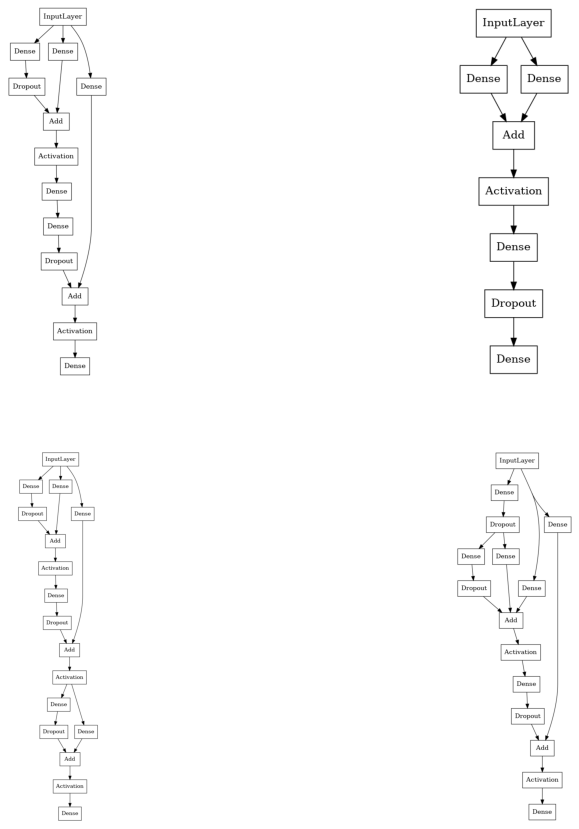

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.utils import plot_model

shapes = dict(input_shape=(10,), output_shape=(1,))
space = ResNetMLPSpace(**shapes).build()

print("Choices: ", space.choices())

images = []
plt.figure(figsize=(15,15))
for i in range(4):
    
    plt.subplot(2,2,i+1)
    model = space.sample()
    plot_model(model, "random_model.png", 
               show_shapes=False, show_layer_names=False) 
    image = mpimg.imread("random_model.png")   
    plt.imshow(image)
    plt.axis('off')

plt.show()

## Create a problem instance

Let us define the neural architecture search problem.

In [7]:
from deephyper.problem import NaProblem
from deephyper.nas.preprocessing import minmaxstdscaler

# Create a Neural Architecture problem
problem = NaProblem()

# Link the load-data function
problem.load_data(load_data)

# The function passed to preprocessing has to return 
# a scikit-learn like preprocessor.
problem.preprocessing(minmaxstdscaler)

# Link the defined search space
problem.search_space(ResNetMLPSpace)

# Fixed hyperparameters for all trained models
problem.hyperparameters(
    batch_size=32,
    learning_rate=0.01,
    optimizer="adam",
    num_epochs=20,
    callbacks=dict(
        EarlyStopping=dict(
            monitor="val_r2", mode="max", verbose=0, patience=5
        )
    ),
)

# Define the optimized loss (it can also be a function)
problem.loss("mse")

# Define metrics to compute for each training and validation epoch
problem.metrics(["r2"])

# Define the maximised objective
problem.objective("val_r2__last")

problem

Problem is:
    - search space   : __main__.ResNetMLPSpace
    - data loading   : __main__.load_data
    - preprocessing  : deephyper.nas.preprocessing._base.minmaxstdscaler
    - hyperparameters: 
        * verbose: 0
        * batch_size: 32
        * learning_rate: 0.01
        * optimizer: adam
        * num_epochs: 20
        * callbacks: {'EarlyStopping': {'monitor': 'val_r2', 'mode': 'max', 'verbose': 0, 'patience': 5}}
    - loss           : mse
    - metrics        : 
        * r2
    - objective      : val_r2__last

Find more about `NaProblem` settings on the [Problem documentation](https://deephyper.readthedocs.io/en/latest/api/deephyper.problem.html).

<div class="alert alert-info">
    
<b>Tip</b>
    

Adding an `EarlyStopping(...)` callback is a good idea to stop the training of your model as soon as it stops to improve.

```python
...
EarlyStopping=dict(monitor="val_r2", mode="max", verbose=0, patience=5)
...
```
    
</div>

## Running the search

Create an `Evaluator` object using the `ray` backend to distribute the evaluation of the run-function. In neural architecture search DeepHyper provides the `run_base_trainer` function which automate the training process of a sampled model.

In [8]:
from deephyper.evaluator import Evaluator
from deephyper.evaluator.callback import LoggerCallback
from deephyper.nas.run import run_base_trainer

from tensorflow.python.client import device_lib


def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == "GPU"]

n_gpus = len(get_available_gpus())
if n_gpus > 1:
    n_gpus -= 1
    
is_gpu_available = n_gpus > 0

if is_gpu_available:
    print(f"{n_gpus} GPU{'s are' if n_gpus > 1 else ' is'} available.")
else:
    print("No GPU available")


from deephyper.evaluator import Evaluator
from deephyper.evaluator.callback import LoggerCallback


def get_evaluator(run_function):
    # Default arguments for Ray: 1 worker and 1 worker per evaluation
    method_kwargs = {
        "num_cpus": 1, 
        "num_cpus_per_task": 1,
        "callbacks": [LoggerCallback()]
    }

    # If GPU devices are detected then it will create 'n_gpus' workers
    # and use 1 worker for each evaluation
    if is_gpu_available:
        method_kwargs["num_cpus"] = n_gpus
        method_kwargs["num_gpus"] = n_gpus
        method_kwargs["num_cpus_per_task"] = 1
        method_kwargs["num_gpus_per_task"] = 1

    evaluator = Evaluator.create(
        run_function, 
        method="ray", 
        method_kwargs=method_kwargs
    )
    print(f"Created new evaluator with {evaluator.num_workers} worker{'s' if evaluator.num_workers > 1 else ''} and config: {method_kwargs}", )
    
    return evaluator

evaluator_1 = get_evaluator(run_base_trainer)

1 GPU is available.


2022-02-08 17:06:46,917	WARNING services.py:1748 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 8589877248 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


Created new evaluator with 1 worker and config: {'num_cpus': 1, 'num_cpus_per_task': 1, 'callbacks': [<deephyper.evaluator.callback.LoggerCallback object at 0x7f2354adccd0>], 'num_gpus': 1, 'num_gpus_per_task': 1}


<div class="alert alert-info">
    
<b>Tip</b> 
    
If executed locally, you can open the ray-dashboard at an address like <a>http://127.0.0.1:port</a> in a browser to monitor the CPU usage of the execution.
    
</div>

Finally, you can define a Random search called `Random` and link to it the defined `problem` and `evaluator`.

In [9]:
from deephyper.search.nas import Random


search = Random(problem, evaluator_1)

In [10]:
if os.path.exists("save/history"):
    histories = [os.path.join("save/history", f) for f in os.listdir("save/history/") if ".json" in f]
    for history in histories:
        os.remove(history)

results = search.search(10)

[00001] -- best objective: 0.92650 -- received objective: 0.92650
[00002] -- best objective: 0.98372 -- received objective: 0.98372
[00003] -- best objective: 0.98372 -- received objective: 0.86692
[00004] -- best objective: 0.98372 -- received objective: 0.95324
[00005] -- best objective: 0.98372 -- received objective: 0.98308
[00006] -- best objective: 0.98372 -- received objective: 0.92806
[00007] -- best objective: 0.98372 -- received objective: 0.83990
[00008] -- best objective: 0.98372 -- received objective: 0.95084
[00009] -- best objective: 0.98372 -- received objective: 0.95946
[00010] -- best objective: 0.98372 -- received objective: 0.95947


After the search is over, you will find the following files in your current folder:

```
results.csv
save/
```

Let us visualize the training of our models. First, we need to load the training history of each model which are located in `save/history`:

In [11]:
import os
import json


histories = [os.path.join("save/history", f) for f in os.listdir("save/history/") if ".json" in f]

for i, fpath in enumerate(histories):
    with open(fpath, "r") as fd:
        histories[i] = json.load(fd)
        
print(list(histories[0].keys()))

['n_parameters', 'training_time', 'loss', 'r2', 'val_loss', 'val_r2']


Text(0.5, 0, 'Epochs')

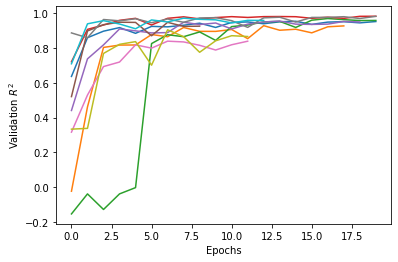

In [12]:
plt.figure()
plt.clf()

for h in histories:
    plt.plot(h["val_r2"])

plt.ylabel("Validation $R^2$")
plt.xlabel("Epochs")


Once the search is over, a file named `results.csv` is saved in the current directory. The same dataframe is returned by the `search.search(...)` call. It contains the configurations evaluated during the search and their corresponding `objective` value (i.e, validation accuracy), `duration` of computation and time of computation with `elapsed_sec`. Each neural architecture is embedded as a list of discrete decision variables called `arch_seq`.

In [13]:
results

,arch_seq,id,objective,elapsed_sec,duration
0,"[141, 9, 0, 18, 1, 1, 1, 107, 7, 1, 0, 0]",1,0.926500,11.809621,10.032212
1,"[79, 1, 1, 122, 9, 1, 0, 20, 7, 1, 1, 1]",2,0.983722,23.449565,11.637924
2,"[176, 4, 0, 70, 6, 0, 0, 55, 10, 0, 1, 0]",3,0.866921,29.163319,5.712235
3,"[14, 3, 0, 168, 6, 1, 0, 86, 8, 1, 1, 0]",4,0.953240,40.255689,11.090811
4,"[137, 1, 1, 72, 9, 0, 0, 42, 8, 1, 1, 1]",5,0.983081,50.510643,10.253556
5,"[117, 8, 1, 169, 1, 0, 1, 159, 10, 0, 0, 1]",6,0.928064,59.988127,9.475830
6,"[9, 6, 0, 71, 6, 0, 1, 18, 9, 0, 1, 0]",7,0.839900,65.971255,5.981527
7,"[52, 8, 0, 144, 7, 1, 0, 158, 7, 0, 0, 0]",8,0.950844,74.751858,8.779223
8,"[176, 4, 0, 6, 2, 0, 0, 121, 5, 1, 0, 0]",9,0.959465,81.056800,6.303795
9,"[92, 10, 1, 63, 9, 1, 1, 140, 10, 0, 0, 1]",10,0.959473,91.721482,10.663341


The `deephyper-analytics` command line is a way of analyzing this type of file. For example, we want to output the best configuration we can use the `topk` functionnality.

In [14]:
!deephyper-analytics topk results.csv -k 3

'0':
  arch_seq: '[79, 1, 1, 122, 9, 1, 0, 20, 7, 1, 1, 1]'
  duration: 11.6379241943
  elapsed_sec: 23.4495651722
  id: 2
  objective: 0.9837219119
'1':
  arch_seq: '[137, 1, 1, 72, 9, 0, 0, 42, 8, 1, 1, 1]'
  duration: 10.2535557747
  elapsed_sec: 50.5106434822
  id: 5
  objective: 0.9830808043
'2':
  arch_seq: '[92, 10, 1, 63, 9, 1, 1, 140, 10, 0, 0, 1]'
  duration: 10.663340807
  elapsed_sec: 91.7214818001
  id: 10
  objective: 0.9594731331



Where each architecture is described as a vector of scalar values named arch_seq. In fact, each of this scalar values represents chosen operations for the variable nodes of our search space. 

## Testing the best configuration

We can visualize the architecture of the best configuration:

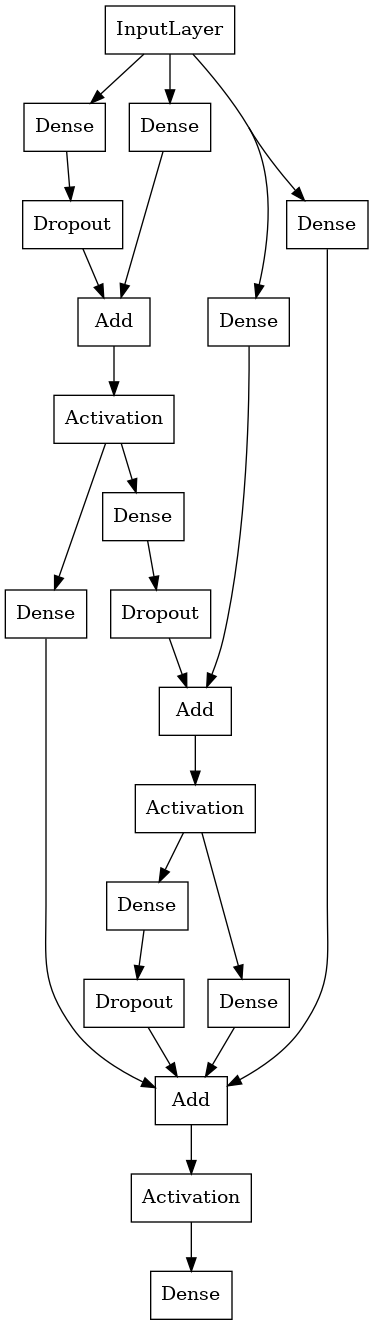

In [15]:
best_config = results.iloc[results.objective.argmax()][:-2].to_dict()
arch_seq = json.loads(best_config["arch_seq"])
model = space.sample(arch_seq)
plot_model(model, show_shapes=False, show_layer_names=False) 